In [393]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
class Features():
    def __init__(self):
        self.feature_matrix = []

    def get_feature_matrix(self, n_actions, observation):
        observation = self.get_engineered_feature(observation)
        num_obs = len(observation)
        features = []
        for j in range(n_actions):
          feature = [[None]*num_obs]*n_actions
          feature[j] = observation
          for i in range(j, n_actions-1+j):
            feature[(i+1)%n_actions] = np.zeros(num_obs)
          features.append(np.array(feature).flatten())
        self.feature_matrix = features
        return features
    
    def get_engineered_feature(self, observation):
      feature=[]
      # for i in range(len(observation)):
      #   for j in range(i + 1, len(observation)):
      #     feature.append(observation[i] * observation[j])
      feature = np.append(observation, feature).reshape(-1,1)
      scaler = MinMaxScaler(feature_range=(-1,1)).fit(np.array(feature))
      scaled = scaler.transform(feature)
      return scaled.flatten()

f = Features().get_feature_matrix(3, np.array([1,3,4]))
f

[array([-1.        ,  0.33333333,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.        ,  0.        ,  0.        , -1.        ,  0.33333333,
         1.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -1.        ,  0.33333333,  1.        ])]

In [396]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder


# class Features():
#     def __init__(self):
#         self.feature_matrix = []

#     def get_feature_matrix(self, n_actions, observation):
#         observation = self.get_engineered_feature(observation)
#         num_obs = len(observation)
#         features = []
#         for j in range(n_actions):
#           feature = [[None]*num_obs]*n_actions
#           feature[j] = observation
#           for i in range(j, n_actions-1+j):
#             feature[(i+1)%n_actions] = np.zeros(num_obs)
#           features.append(np.array(feature).flatten())
#         self.feature_matrix = features
    
#     # def get_action(self, observation):
#     #     features =self.get_feature_matrix(observation)
#     #     action = np.argmax([feature for feature in features])
#     #     delta = reward + self.gamma*max([feature for feature in features])
#     #     self.w = (1-self.alpha)*(self.w) + self.alpha*(features[action]*delta) 

#     def get_engineered_feature(self, observation):
#       return observation
    
class CartPoleEnvLinear(gym.Env):

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self, render_mode="rgb_array", n_observations=1000, q_table=np.array(None), alpha=0.9):
      self.env = gym.make("CartPole-v1", render_mode=render_mode)
      self.action_space = self.env.action_space
      self.n_actions = 2
      self.observation_space = self.env.observation_space
      self.n_observation_space = 4
      self.n_buckets = 4
      self.bucket_size = self.env.observation_space.high / (self.n_buckets/2)
      self.q_table =  np.zeros((self.env.action_space.n, np.power(self.n_buckets, self.n_observation_space))) if not q_table.all() else q_table
      self.epsilon = n_observations/2
      self.n_observations = n_observations
      self.epsilon_delta = self.epsilon / self.n_observations
      self.metric = []
      self.test_metric = []
      self.alpha = alpha
      self.gamma =  0.9
      self.w = np.zeros(self.n_observation_space*2)
      self.features = Features()
      self.epsilon_greedy_curve = []
      return 
    
    def get_index(self, observation):
      observation_bucketed = self.bucket_observation(observation)
      i = len(observation_bucketed) - 1
      idx = 0
      for el in observation_bucketed:
        idx = idx + (self.n_buckets**i * el)
        i -= 1
      return int(idx)
    
    def bucket_observation(self, observation):
      return(np.floor(observation/self.bucket_size))

    def update_q_table(self, observation, observation_prime, reward, action=1):
        action, features = self.get_action(observation=observation)
        max_future_reward = self.get_max_future_reward(observation=observation_prime)
        delta = reward + self.gamma*max_future_reward
        self.w = (1-self.alpha)*(self.w) + self.alpha*(features[action]*delta)

    def policy(self, observation):   
      prob = self.get_epsilon_greedy_probability() #at first, low probability to read from q-table, ie high prob take random action
      take_random_action = prob < np.random.random()
      if take_random_action:
        return self.action_space.sample()
      else:
        action, _ = self.get_action(observation)
        return action
      
    def get_epsilon_greedy_probability(self):
      x = self.epsilon
      self.epsilon = self.epsilon - 1
      prob = np.max((1/(1+np.exp(-x*10/self.n_observations)), 0))
      self.epsilon_greedy_curve.append(prob)
      return prob
      
    def get_action(self, observation):
       features = self.features.get_feature_matrix(n_actions=self.n_actions, observation=observation)
       action = np.argmax([feature.dot(self.w) for feature in features])
       return action, features
       
    def get_max_future_reward(self, observation):
      features = self.features.get_feature_matrix(n_actions=self.n_actions, observation=observation)
      max_reward = np.max([feature.dot(self.w) for feature in features])
      return max_reward
    
    def train(self):
        observation, _ = self.env.reset()
        j=0
        for i in range(self.n_observations):
          action = self.policy(observation)
          observation_prime, reward, terminated, truncated, info = self.env.step(action)
          self.update_q_table(observation, observation_prime, reward, action)
          observation = observation_prime
          j +=1
          if terminated or truncated:
            self.metric.append(j)
            j=0
            observation, info = self.env.reset()
            # print(info)
        self.env.close()
      
    def test(self):
        vid = VideoRecorder(self.env, enabled=True, path="./qlearning_linear_test_video/vid.mp4")
        observation, _ = self.env.reset()
        j = 0
        for i in range(1000):
            features = self.features.get_feature_matrix(n_actions=self.n_actions, observation=observation)
            action = np.argmax([feature.dot(self.w) for feature in features])
            vid.capture_frame()
            observation, reward, terminated, truncated, info = self.env.step(action)
            j += 1
            if terminated or truncated:
              self.test_metric.append(j)
              j = 0
              observation, _ = self.env.reset()
        self.env.reset()
        self.env.close()
        vid.close()

/Users/jadon/Documents/cart-pole/RL-for-DPIC/cart-pole-env/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video ./qlearning_linear_test_video/vid.mp4.
Moviepy - Writing video ./qlearning_linear_test_video/vid.mp4



Moviepy - Done !
Moviepy - video ready ./qlearning_linear_test_video/vid.mp4
[ 2.69892287e+03  6.75742725e+03  8.53837725e+02 -6.75742725e+03
  1.20452341e-14 -1.46066886e-13  1.52541889e-14  1.37673841e-13]
67.78571428571429
62.5
[ 8.   9.  10.  14.  31.8 65.2 89. ]


(array([0., 1., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([39., 44., 49., 54., 59., 64., 69., 74., 79., 84., 89.]),
 <BarContainer object of 10 artists>)

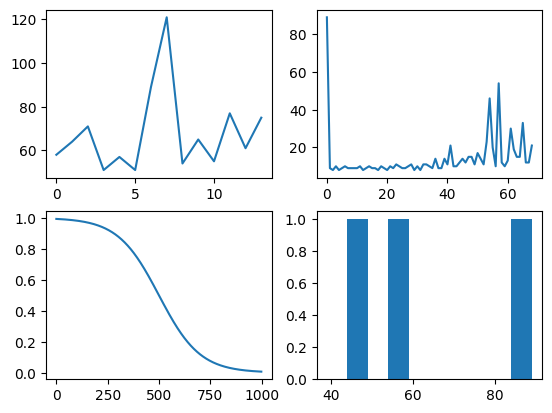

In [406]:
env = CartPoleEnvLinear(n_observations=1000)
fig, ax = plt.subplots(2,2)
ax = ax.flat
env.train()
env.test()
print(env.w)
print(np.mean(env.test_metric))
print(np.median(env.test_metric))
print(np.quantile(env.metric, [0, 0.25, 0.5, 0.75, .95, .99, 1]))
ax[0].plot(np.array(env.test_metric))
ax[1].plot(env.metric)
ax[2].plot(env.epsilon_greedy_curve)
ax[3].hist(env.metric, bins=10, range=[np.max(env.metric)-50,np.max(env.metric)])

In [403]:
env.metric

[69, 12]

In [296]:
# y = []
# z = []
# r = 100
# alpha = 0.1
# seq = np.arange(-r, r)
# for x in seq:
#     y.append(np.max((1/(1+np.exp(-x*5/r)), 0))) 
#     z.append(alpha*(1/(r-x)))
# # plt.plot(-np.array(y))
# plt.plot(z)